In [1]:
#importing packages
import numpy as np 
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import time
from scipy.signal import convolve2d
from sklearn import metrics

from keras.datasets import mnist
import pandas as pd

from Utilities import *

import cv2

#### Downloading MNIST dataset and  Zero-padding & Normalization to the training data

In [2]:
#Downloading mnist dataset
(train_image, train_label), (test_image, test_label) = mnist.load_data()

In [3]:
print("Shape of training images is:", train_image.shape)
print("Shape of testing images is: ", test_image.shape)

print("Shape of a single image is: ", train_image[0].shape)
print(train_label.shape)
print(test_label.shape)

Shape of training images is: (60000, 28, 28)
Shape of testing images is:  (10000, 28, 28)
Shape of a single image is:  (28, 28)
(60000,)
(10000,)


In [4]:
#Zero-padding & Normalization to the training data
train_image_normalized_pad = normalize(zero_pad(train_image[:,:,:,np.newaxis], 2),'LeNet')
test_image_normalized_pad  = normalize(zero_pad(test_image[:,:,:,np.newaxis],  2),'LeNet')
print("The shape of training image with padding:", train_image_normalized_pad.shape)
print("The shape of testing image with padding: ", test_image_normalized_pad.shape)

The shape of training image with padding: (60000, 32, 32, 1)
The shape of testing image with padding:  (10000, 32, 32, 1)


### Q 2.1 Inner Product Layer

In [5]:
# function implemented within a class  
class FCLayer(object):
    def __init__(self, weight_shape, init_mode='Gaussian_dist'): 
        
        # Initialization
        self.v_w, self.v_b = np.zeros(weight_shape), np.zeros((weight_shape[-1],))
        self.weight, self.bias = initialize(weight_shape, init_mode)
    
    #Q 2.1 Inner Product Layer   
    def foward_prop(self, input_array):
        self.input_array = input_array  #(n_m, 120)
        return np.matmul(self.input_array, self.weight) # (n_m, 84)
    
    #Q 3.2 Inner Product layer   
    def back_prop(self, dZ, momentum, weight_decay):
        dA = np.matmul(dZ, self.weight.T)               # (n_m, 84) * (84, 120) = (n_m, 120)
        dW = np.matmul(self.input_array.T, dZ)          # (n_m, 120).T * (n_m, 84) = (120, 84)
        db = np.sum(dZ.T, axis=1)                       # (84,)
        
        self.weight, self.bias, self.v_w, self.v_b = \
            update(self.weight, self.bias, dW, db, self.v_w, self.v_b, self.lr, momentum, weight_decay)
        return dA
    
    # Stochastic Diagonal Levenberg-Marquaedt
    def SDLM(self, d2Z, mu, lr_global):
        d2A = np.matmul(d2Z, np.power(self.weight.T,2))
        d2W = np.matmul(np.power(self.input_array.T,2), d2Z)
        h = np.sum(d2W)/d2Z.shape[0]
        self.lr = lr_global / (mu + h)
        return d2A

### Q 2.2 Pooling Layer

In [6]:
def pooling_layer_forward(A_prev, hparameters, mode):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    A = np.zeros((m, n_H, n_W, n_C))      
    for h in range(n_H):                      # loop on the vertical axis of the output volume
        for w in range(n_W):                  # loop on the horizontal axis of the output volume
            # Use the corners to define the current slice on the ith training example of A_prev, channel c
            A_prev_slice = A_prev[:, h*stride:h*stride+f, w*stride:w*stride+f, :]  
            # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. 
            if mode == "max":
                A[:, h, w, :] = np.max(A_prev_slice, axis=(1,2))
            elif mode == "average":
                A[:, h, w, :] = np.average(A_prev_slice, axis=(1,2))

    cache = (A_prev, hparameters)
    assert(A.shape == (m, n_H, n_W, n_C))
    return A, cache


### Q 2.3 Convolution Layer

In [7]:
def conv_layer_forward(A_prev, W, b, hparameters):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev + 2*pad - f)/stride + 1)
    n_W = int((n_W_prev + 2*pad - f)/stride + 1)
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((m, n_H, n_W, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    for h in range(n_H):                            # loop over vertical axis of the output volume
        for w in range(n_W):                        # loop over horizontal axis of the output volume
            A_slice_prev = A_prev_pad[:, h*stride:h*stride+f, w*stride:w*stride+f, :]
            Z[:, h, w, :] = np.tensordot(A_slice_prev, W, axes=([1,2,3],[0,1,2])) + b
                            
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)
    return Z, cache

### Q 2.4 ReLU forward propagation

In [8]:
#ReLU activation
def relu_forward(inputs):
    return np.where(inputs>0, inputs, 0)

### Q 3.1 ReLU backward propagation

In [9]:
def relu_backward(inputs):
    return np.where(inputs>0, 1, 0)

### Q 3.2 Inner Product layer backpropagation

In [10]:
"""Code for this is implemented above under Q 2.1 Inner Product Layer in FCLayer class"""

'Code for this is implemented above under Q 2.1 Inner Product Layer in FCLayer class'

#### Helper functions for ReLU layer

In [11]:
#Helper activation functions
def tanh(x):
    return np.tanh(x)
def d_tanh(x):
    return 1/np.power(np.cosh(x),2)

def LeNet_squash(x):
    return 1.7159*np.tanh(2*x/3)
def d_LeNet_squash(x):
    return 1.14393*(1-np.power(tanh(2*x/3),2))

def activation_func():
    actf = [LeNet_squash, tanh, relu_forward]
    actfName = [act.__name__ for act in actf]
    d_actf = [d_LeNet_squash, d_tanh, relu_backward]
    d_actfName = [d_act.__name__ for d_act in d_actf]
    return (actf, d_actf), actfName


### Helper classes to LeNet Layers above

In [12]:
class ConvLayer(object):
    def __init__(self, kernel_shape, hparameters, init_mode='Gaussian_dist'):
        self.hparameters = hparameters
        self.weight, self.bias = initialize(kernel_shape, init_mode)
        self.v_w, self.v_b = np.zeros(kernel_shape), np.zeros((1,1,1,kernel_shape[-1]))
        
    def foward_prop(self, input_map):
        output_map, self.cache = conv_layer_forward(input_map, self.weight, self.bias, self.hparameters)
        return output_map
    
    def back_prop(self, dZ, momentum, weight_decay):
        dA_prev, dW, db = conv_backward(dZ, self.cache)
        self.weight, self.bias, self.v_w, self.v_b = \
            update(self.weight, self.bias, dW, db, self.v_w, self.v_b, self.lr, momentum, weight_decay)
        return dA_prev  
    
    def SDLM(self, d2Z, mu, lr_global):
        d2A_prev, d2W = conv_SDLM(d2Z, self.cache)
        h = np.sum(d2W)/d2Z.shape[0]
        self.lr = lr_global / (mu + h)
        return d2A_prev 
    
# Conv3: Convlayer with assigned combination between input maps and weight
class ConvLayer_maps(object):
    def __init__(self, kernel_shape, hparameters, mapping, init_mode='Gaussian_dist'):
        self.hparameters = hparameters
        self.mapping     = mapping
        self.wb   = []      # list of [weight, bias]
        self.v_wb = []      # list of [v_w,    v_b]
        for i in range(len(self.mapping)):
            weight_shape = (kernel_shape[0], kernel_shape[1], len(self.mapping[i]), 1)
            w, b = initialize(weight_shape, init_mode)
            self.wb.append([w, b])
            self.v_wb.append([np.zeros(w.shape), np.zeros(b.shape)])
        
    def foward_prop(self, input_map):
        self.iputmap_shape = input_map.shape #(n_m,14,14,6)
        self.caches = []
        output_maps = []
        for i in range(len(self.mapping)):
            output_map, cache = conv_layer_forward(input_map[:,:,:,self.mapping[i]], self.wb[i][0], self.wb[i][1], self.hparameters)
            output_maps.append(output_map)
            self.caches.append(cache)
        output_maps = np.swapaxes(np.array(output_maps),0,4)[0]
        return output_maps
    
    def back_prop(self, dZ, momentum, weight_decay):
        dA_prevs = np.zeros(self.iputmap_shape)
        for i in range(len(self.mapping)):
            dA_prev, dW, db = conv_backward(dZ[:,:,:,i:i+1], self.caches[i])
            self.wb[i][0], self.wb[i][1], self.v_wb[i][0], self.v_wb[i][1] =\
                update(self.wb[i][0], self.wb[i][1], dW, db, self.v_wb[i][0], self.v_wb[i][1], self.lr, momentum, weight_decay)
            dA_prevs[:,:,:,self.mapping[i]] += dA_prev
        return dA_prevs 
    
    # Stochastic Diagonal Levenberg-Marquaedt
    def SDLM(self, d2Z, mu, lr_global):
        h = 0
        d2A_prevs = np.zeros(self.iputmap_shape)
        for i in range(len(self.mapping)):
            d2A_prev, d2W = conv_SDLM(d2Z[:,:,:,i:i+1], self.caches[i])
            d2A_prevs[:,:,:,self.mapping[i]] += d2A_prev
            h += np.sum(d2W)
        self.lr = lr_global / (mu + h/d2Z.shape[0])
        return d2A_prevs

class PoolingLayer(object):
    def __init__(self, hparameters, mode):
        self.hparameters = hparameters
        self.mode = mode
        
    def foward_prop(self, input_map):   # n,28,28,6 / n,10,10,16
        A, self.cache = pooling_layer_forward(input_map, self.hparameters, self.mode)
        return A
    
    def back_prop(self, dA):
        dA_prev = pool_backward(dA, self.cache, self.mode)
        return dA_prev
    
    def SDLM(self, d2A):
        d2A_prev = pool_backward(d2A, self.cache, self.mode)
        return d2A_prev

class Activation(object):
    def __init__(self, mode):    
        (act, d_act), actfName = activation_func()
        act_index  = actfName.index(mode)
        self.act   = act[act_index]
        self.d_act = d_act[act_index]
        
    def foward_prop(self, input_image): 
        self.input_image = input_image
        return self.act(input_image)
    
    def back_prop(self, dZ):
        dA = np.multiply(dZ, self.d_act(self.input_image)) 
        return dA
    
    # Stochastic Diagonal Levenberg-Marquaedt
    def SDLM(self, d2Z):  #d2_LeNet_squash
        dA = np.multiply(d2Z, np.power(self.d_act(self.input_image),2)) 
        return dA

# not even slightly work
class RBFLayer_trainable_weight(object):
    def __init__(self, weight_shape, init_weight=None, init_mode='Gaussian_dist'): 
        self.weight_shape = weight_shape # =(10, 84)
        self.v_w = np.zeros(weight_shape)

        if init_weight.shape == (10,84):
            self.weight = init_weight
        else:
            self.weight, _ = initialize(weight_shape, init_mode)
        
    def foward_prop(self, input_array, label, mode): 
        
        if mode == 'train':
            self.input_array = input_array
            self.weight_label = self.weight[label,:]  #(n_m, 84) labeled version of weight
            loss = 0.5 * np.sum(np.power(input_array - self.weight_label, 2), axis=1, keepdims=True)  #(n_m, )
            return np.sum(np.squeeze(loss))
        
        if mode == 'test':
            subtract_weight = (input_array[:,np.newaxis,:] - np.array([self.weight]*input_array.shape[0])) # (n_m,10,84)
            rbf_class = np.sum(np.power(subtract_weight,2), axis=2) # (n_m, 10)
            class_pred = np.argmin(rbf_class, axis=1) # (n_m,)
            error01 = np.sum(label != class_pred)
            return error01, class_pred

    def back_prop(self, label, lr, momentum, weight_decay):
        
        dy_predict = -self.weight_label + self.input_array    #(n_m, 84)
        
        dW_target  = -dy_predict                              #(n_m, 84)
        
        dW = np.zeros(self.weight_shape) # (10,84)
        
        for i in range(len(label)):  
            dW[label[i],:] += dW_target[i,:]
            
        self.v_w = momentum*self.v_w - weight_decay*lr*self.weight - lr*dW
        self.weight += self.v_w

        return dy_predict

bitmap = rbf_init_weight()

class RBFLayer(object):
    def __init__(self, weight):        
        self.weight = weight  # (10, 84)
        
    def foward_prop(self, input_array, label, mode): 
        if mode == 'train':
            self.input_array = input_array
            self.weight_label = self.weight[label,:]  #(n_m, 84) labeled version of weight
            loss = 0.5 * np.sum(np.power(input_array - self.weight_label, 2), axis=1, keepdims=True)  #(n_m, )
            return np.sum(np.squeeze(loss))
        if mode == 'test':
            # (n_m,1,84) - n_m*[(10,84)] = (n_m,10,84)
            subtract_weight = (input_array[:,np.newaxis,:] - np.array([self.weight]*input_array.shape[0])) # (n_m,10,84)
            rbf_class = np.sum(np.power(subtract_weight,2), axis=2) # (n_m, 10)
            class_pred = np.argmin(rbf_class, axis=1) # (n_m,)
            error01 = np.sum(label != class_pred)
            return error01, class_pred
        
    def back_prop(self):
        dy_predict = -self.weight_label + self.input_array    #(n_m, 84)
        return dy_predict
    
    def SDLM(self):
        # d2y_predict
        return np.ones(self.input_array.shape)
    

In [13]:
# Designate combination of kernels and feature maps of MaxP2.
Conv3_mapping = [[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,0],[5,0,1],\
              [0,1,2,3],[1,2,3,4],[2,3,4,5],[3,4,5,0],[4,5,0,1],[5,0,1,2],\
              [0,1,3,4],[1,2,4,5],[0,2,3,5],\
              [0,1,2,3,4,5]]

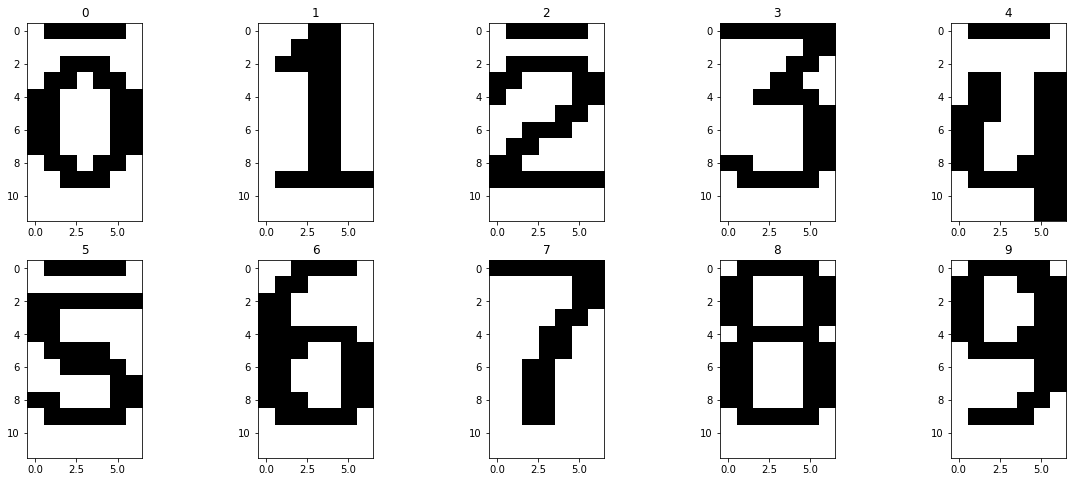

In [14]:
# The fixed weight (7x12 preset ASCII bitmaps) used in the RBF layer.
bitmap = rbf_init_weight()
fig, axarr = plt.subplots(2,5,figsize=(20,8))
for i in range(10):
    x,y = int(i/5), i%5
    axarr[x,y].set_title(str(i))
    axarr[x,y].imshow(bitmap[i,:].reshape(12,7), cmap=mpl.cm.Greys)

### Class that puts everything together

In [15]:
# LeNet object (also stored in utils/LayerObjects.py)
class LeNet(object):
    def __init__(self):
        kernel_shape = {"Conv1": (5,5,1,6),
                        "Conv3": (5,5,6,16),    ### Conv3 has designated combinations
                        "Conv5": (5,5,16,120),  ### It's actually a FC layer
                        "FCL6": (120,84),
                        "OUTPUT": (84,10)}
        
        hparameters_convlayer = {"stride": 1, "pad": 0}
        hparameters_pooling   = {"stride": 2, "f": 2}        
        
        self.Conv1 = ConvLayer(kernel_shape["Conv1"], hparameters_convlayer)
        self.a1 = Activation("LeNet_squash")
        self.MaxP2 = PoolingLayer(hparameters_pooling, "average")
        
        self.Conv3 = ConvLayer_maps(kernel_shape["Conv3"], hparameters_convlayer, Conv3_mapping)
        self.a2 = Activation("LeNet_squash")
        self.MaxP4 = PoolingLayer(hparameters_pooling, "average")
        
        self.Conv5 = ConvLayer(kernel_shape["Conv5"], hparameters_convlayer)
        self.a3 = Activation("LeNet_squash")

        self.FCL6 = FCLayer(kernel_shape["FCL6"])
        self.a4 = Activation("LeNet_squash")
        
        self.Output = RBFLayer(bitmap)
        
    def Forward_Propagation(self, input_image, input_label, mode): 
        self.label = input_label
        self.Conv1_FP = self.Conv1.foward_prop(input_image)
        self.a1_FP = self.a1.foward_prop(self.Conv1_FP)
        self.MaxP2_FP = self.MaxP2.foward_prop(self.a1_FP)

        self.Conv3_FP = self.Conv3.foward_prop(self.MaxP2_FP)
        self.a2_FP = self.a2.foward_prop(self.Conv3_FP)
        self.MaxP4_FP = self.MaxP4.foward_prop(self.a2_FP)

        self.Conv5_FP = self.Conv5.foward_prop(self.MaxP4_FP)
        self.a3_FP = self.a3.foward_prop(self.Conv5_FP)

        self.flatten = self.a3_FP[:,0,0,:]
        self.FCL6_FP = self.FCL6.foward_prop(self.flatten)
        self.a4_FP = self.a4.foward_prop(self.FCL6_FP)  
        
        # output sum of the loss over mini-batch when mode = 'train'
        # output tuple of (0/1 error, class_predict) when mode = 'test'
        out  = self.Output.foward_prop(self.a4_FP, input_label, mode) 

        return out 
        
    def Back_Propagation(self, momentum, weight_decay):
        dy_pred = self.Output.back_prop()
        
        dy_pred = self.a4.back_prop(dy_pred)
        FCL6_BP = self.FCL6.back_prop(dy_pred, momentum, weight_decay)
        reverse_flatten = FCL6_BP[:,np.newaxis,np.newaxis,:]
        
        reverse_flatten = self.a3.back_prop(reverse_flatten) 
        Conv5_BP = self.Conv5.back_prop(reverse_flatten, momentum, weight_decay)
        
        MaxP4_BP = self.MaxP4.back_prop(Conv5_BP)
        MaxP4_BP = self.a2.back_prop(MaxP4_BP)
        Conv3_BP = self.Conv3.back_prop(MaxP4_BP, momentum, weight_decay) 
        
        MaxP2_BP = self.MaxP2.back_prop(Conv3_BP)
        MaxP2_BP = self.a1.back_prop(MaxP2_BP)  
        Conv1_BP = self.Conv1.back_prop(MaxP2_BP, momentum, weight_decay)
        
    # Stochastic Diagonal Levenberg-Marquaedt method for determining the learning rate before the beginning of each epoch
    def SDLM(self, mu, lr_global):
        d2y_pred = self.Output.SDLM()
        d2y_pred = self.a4.SDLM(d2y_pred)
        
        FCL6_SDLM = self.FCL6.SDLM(d2y_pred, mu, lr_global)
        reverse_flatten = FCL6_SDLM[:,np.newaxis,np.newaxis,:]
        
        reverse_flatten = self.a3.SDLM(reverse_flatten) 
        Conv5_SDLM = self.Conv5.SDLM(reverse_flatten, mu, lr_global)
        
        MaxP4_SDLM = self.MaxP4.SDLM(Conv5_SDLM)
        MaxP4_SDLM = self.a2.SDLM(MaxP4_SDLM)
        Conv3_SDLM = self.Conv3.SDLM(MaxP4_SDLM, mu, lr_global)
        
        MaxP2_SDLM = self.MaxP2.SDLM(Conv3_SDLM)
        MaxP2_SDLM = self.a1.SDLM(MaxP2_SDLM)  
        Conv1_SDLM = self.Conv1.SDLM(MaxP2_SDLM, mu, lr_global)

In [16]:
ConvNet = LeNet()

###  Training and Testing

In [17]:
# Number of epoches & learning rate in the original paper
epoch_orig, lr_global_orig = 20, np.array([5e-4]*2 + [2e-4]*3 + [1e-4]*3 + [5e-5]*4 + [1e-5]*8) 

# Number of epoches & learning rate I used
epoches, lr_global_list = epoch_orig, lr_global_orig*100

momentum = 0.9
weight_decay = 0
batch_size = 256

#### Training

In [ ]:
#Training loops
st = time.time()
cost_last, count = np.Inf, 0
err_rate_list = []
for epoch in range(0,epoches):
    print("---------- epoch", epoch+1, "begin ----------")
    
    # Stochastic Diagonal Levenberg-Marquaedt method for determining the learning rate 
    (batch_image, batch_label) = random_mini_batches(train_image_normalized_pad, train_label, mini_batch_size = 500, one_batch=True)
    ConvNet.Forward_Propagation(batch_image, batch_label, 'train')
    lr_global = lr_global_list[epoch]
    ConvNet.SDLM(0.02, lr_global)
    
    # print info
    print("global learning rate:", lr_global)
    print("learning rates in trainable layers:", np.array([ConvNet.Conv1.lr, ConvNet.Conv3.lr, ConvNet.Conv5.lr, ConvNet.FCL6.lr]))
    print("batch size:", batch_size)
    print("Momentum:",momentum,", weight decay:",weight_decay)
    
    #loop over each batch
    ste = time.time()
    cost = 0
    mini_batches = random_mini_batches(train_image_normalized_pad, train_label, batch_size)
    for i in range(len(mini_batches)):
        batch_image, batch_label = mini_batches[i]
        
        loss = ConvNet.Forward_Propagation(batch_image, batch_label, 'train')     
        cost += loss
        
        ConvNet.Back_Propagation(momentum, weight_decay) 

        # print progress
        if i%(int(len(mini_batches)/100))==0:
            sys.stdout.write("\033[F")   #CURSOR_UP_ONE
            sys.stdout.write("\033[K")   #ERASE_LINE
            print ("progress:", int(100*(i+1)/len(mini_batches)), "%, ", "cost =", cost, end='\r')
    sys.stdout.write("\033[F")   #CURSOR_UP_ONE
    sys.stdout.write("\033[K")   #ERASE_LINE
    
    print ("Done, cost of epoch", epoch+1, ":", cost,"                                             ")
    
    error01_train, _ = ConvNet.Forward_Propagation(train_image_normalized_pad, train_label, 'test')  
    error01_test, _  = ConvNet.Forward_Propagation(test_image_normalized_pad,  test_label,  'test')     
    err_rate_list.append([error01_train/60000, error01_test/10000])
    print("0/1 error of training set:",  error01_train, "/", len(train_label))
    print("0/1 error of testing set: ",  error01_test,  "/", len(test_label))
    print("Time used: ",time.time() - ste, "sec")
    print("---------- epoch", epoch+1, "end ------------")
    with open('model_data_'+str(epoch)+'.pkl', 'wb') as output:
        pickle.dump(ConvNet, output, pickle.HIGHEST_PROTOCOL)
    %notebook -e output.ipynb
    
err_rate_list = np.array(err_rate_list).T
print("Total time used: ", time.time() - st, "sec")

---------- epoch 1 begin ----------
global learning rate: 0.05
learning rates in trainable layers: [1.89168415e-05 1.15641276e-05 1.95795304e-05 1.98585574e-05]
batch size: 256
Momentum: 0.9 , weight decay: 0


###  Q 4.1 Training

In [ ]:
# read model
with open('model_data_13.pkl', 'rb') as input_:
    ConvNet = pickle.load(input_)
    
print("Correct label:",test_label)
_, pred = ConvNet.Forward_Propagation(test_image_normalized_pad, test_label, 'test')
print("Predict label:",pred)

y_pred = pred
y_test = test_label

print()
print("Cassification report is:\n ",metrics.classification_report(y_test, y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

print("Accuracy is: ", metrics.accuracy_score(y_test, y_pred))

### Q 4.2 Test the network

In [ ]:
print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

### Q5.1 Output of second layer

In [ ]:
MaxP2_FP = ConvNet.MaxP2_FP[0]
print("Output of second layer")
# Feature maps of C1
fig, axarr = plt.subplots(1,5,figsize=(18,5))
for j in range(5):
    axarr[j].axis('off') 
    #axarr[j].set_title( 'layer2_map'+str(j+1))
    axarr[j].imshow(MaxP2_FP[:,:,j], cmap=mpl.cm.Greys)
    


In [ ]:
'''# Feature maps of C3
MaxP2 = ConvNet.MaxP2_FP[0]

print("Output of third layer")

fig, axarr = plt.subplots(4,5,figsize=(18,5))

for x in range(4):
    for y in range(5):
    #x,y = int(j/8), j%8
        j = x*4+y
        axarr[x,y].axis('off') 
        #axarr[x,y].set_title( 'layer3_map'+str(j+1))
        axarr[x,y].imshow(MaxP2[:,:,j-1], cmap=mpl.cm.Greys)'''

### Q5.1 Output of third layer 

In [ ]:
# Feature maps of C3
Conv3map = ConvNet.Conv3_FP[0]

print("Output of third layer")

fig, axarr = plt.subplots(4,5,figsize=(18,5))

for x in range(4):
    for y in range(5):
        j = x*4+y
        axarr[x,y].axis('off') 
        axarr[x,y].imshow(Conv3map[:,:,j-1], cmap=mpl.cm.Greys)

### Q5.2 Comparing feature maps to original image

In [ ]:
# The fixed weight (7x12 preset ASCII bitmaps) used in the RBF layer.
print("Original images are: \n")
fig, axarr = plt.subplots(2,5,figsize=(20,8))
for i in range(10):
    x,y = int(i/5), i%5
    axarr[x,y].set_title(str(i))
    axarr[x,y].imshow(train_image[i, :, :], cmap=mpl.cm.Greys)

### Extra credit 

#### Part 6 Image Classication

In [ ]:
img1 = cv2.imread("image1.jpg")
print(img1.shape)

img2 = cv2.imread("image2.jpg")
print(img1.shape)

img3 = cv2.imread("image3.png")
print(img3.shape)

img4 = cv2.imread("image4.jpg")
print(img1.shape)